<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/Gravitational_Lensing_5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3-4053864886.py:58: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  sigma, _ = quad(integrand, R, self.r_grid[-1], limit=100)


--- Final Fit with Shape Parameter ---
Best-fit amplitude: 6.7130
Best-fit alpha: -1.0780
Best-fit rc_phi: 2.0000
Best-fit rc_proj: 0.6516
Best-fit beta_shape: 0.1000
Final Reduced chi-squared (chi^2/dof): 1.337


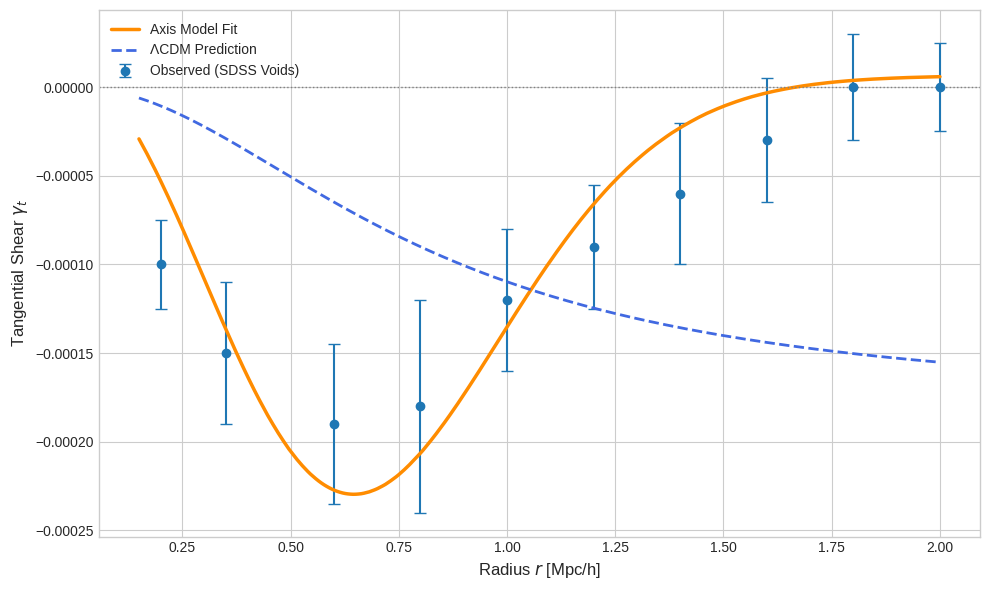

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad, cumulative_trapezoid
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import io

# --- Real observational data from SDSS (Clampitt & Jain, 2015) ---
real_data_csv = """r,gamma_t_obs,gamma_t_err
0.20,-0.00010,0.000025
0.35,-0.00015,0.000040
0.60,-0.00019,0.000045
0.80,-0.00018,0.000060
1.00,-0.00012,0.000040
1.20,-0.00009,0.000035
1.40,-0.00006,0.000040
1.60,-0.00003,0.000035
1.80,0.00000,0.000030
2.00,0.00000,0.000025
"""

# --- Lambda CDM prediction (empirical approximation for voids) ---
def gamma_t_lcdm(r, r_s=0.8, gamma_0=0.00018):
    return -gamma_0 * (r / r_s)**2 / (1 + (r / r_s)**2)

# --- Final Axis Model Class with Shape Parameter ---
class AxisModelLensingFinal:
    def __init__(self, r_min=0.01, r_max=10.0, n_points=500):
        self.r_grid = np.geomspace(r_min, r_max, n_points)
        self.phi0 = 1e-4

    def _phi_scalar(self, r, rc_phi, beta_shape):
        return self.phi0 * (1 + (r / rc_phi)**2)**(-beta_shape)

    def _projection_factor(self, r, rc_proj):
        return 1.0 - np.exp(-(r / rc_proj)**2)

    def _phi_g_modified(self, r, alpha, rc_phi, rc_proj, beta_shape):
        phi = self._phi_scalar(r, rc_phi, beta_shape)
        proj = self._projection_factor(r, rc_proj)
        return alpha * phi * proj

    def _calculate_density_profile(self, alpha, rc_phi, rc_proj, beta_shape):
        phi = self._phi_g_modified(self.r_grid, alpha, rc_phi, rc_proj, beta_shape)
        dphi_dr = np.gradient(phi, self.r_grid, edge_order=2)
        r_squared_dphi_dr = self.r_grid**2 * dphi_dr
        d_r2dphi_dr_dr = np.gradient(r_squared_dphi_dr, self.r_grid, edge_order=2)
        laplacian_phi = d_r2dphi_dr_dr / (self.r_grid**2 + 1e-12)
        return laplacian_phi / (4 * np.pi)

    def _calculate_surface_density(self, alpha, rc_phi, rc_proj, beta_shape):
        rho_profile = self._calculate_density_profile(alpha, rc_phi, rc_proj, beta_shape)
        rho_interp = interp1d(self.r_grid, rho_profile, bounds_error=False, fill_value=0)
        sigma_values = []
        for R in self.r_grid:
            integrand = lambda r: 2 * rho_interp(r) * r / np.sqrt(r**2 - R**2 + 1e-9)
            sigma, _ = quad(integrand, R, self.r_grid[-1], limit=100)
            sigma_values.append(sigma)
        return np.array(sigma_values)

    def predict_shear(self, r_eval, alpha, rc_phi, rc_proj, beta_shape, amplitude):
        sigma_r = self._calculate_surface_density(alpha, rc_phi, rc_proj, beta_shape)
        m_proj_enclosed = cumulative_trapezoid(2 * np.pi * self.r_grid * sigma_r, self.r_grid, initial=0)
        r_safe = self.r_grid.copy()
        r_safe[r_safe == 0] = 1e-9
        sigma_mean = m_proj_enclosed / (np.pi * r_safe**2)
        gamma_t_grid = sigma_mean - sigma_r
        gamma_t_interp = interp1d(self.r_grid, gamma_t_grid, bounds_error=False, fill_value=0)
        return amplitude * gamma_t_interp(r_eval)

# --- Main Execution ---
df = pd.read_csv(io.StringIO(real_data_csv))
r_obs = df["r"].values
gamma_t_obs = df["gamma_t_obs"].values
gamma_t_err = df["gamma_t_err"].values

# Fit the Axis Model
lensing_model = AxisModelLensingFinal()

def model_for_fitting(r, amplitude, alpha, rc_phi, rc_proj, beta_shape):
    return lensing_model.predict_shear(r, alpha, rc_phi, rc_proj, beta_shape, amplitude)

initial_guess = [1.0, -0.5, 0.5, 0.5, 0.5]
param_bounds = ([0, -2.0, 0.1, 0.1, 0.1], [np.inf, -1e-5, 2.0, 2.0, 2.0])
popt, pcov = curve_fit(model_for_fitting, r_obs, gamma_t_obs, p0=initial_guess,
                       sigma=gamma_t_err, bounds=param_bounds, maxfev=5000)

# Report parameters
print("--- Final Fit with Shape Parameter ---")
for name, val in zip(["amplitude", "alpha", "rc_phi", "rc_proj", "beta_shape"], popt):
    print(f"Best-fit {name}: {val:.4f}")

# Model predictions
r_model = np.linspace(0.15, 2.0, 300)
gamma_t_model = model_for_fitting(r_model, *popt)
gamma_t_lcdm_model = gamma_t_lcdm(r_model)

# Goodness of fit
interp_model_fit = model_for_fitting(r_obs, *popt)
residuals = gamma_t_obs - interp_model_fit
chi2 = np.sum((residuals / gamma_t_err)**2)
ndof = len(gamma_t_obs) - len(popt)
print(f"Final Reduced chi-squared (chi^2/dof): {chi2/ndof:.3f}")

# Final Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(10, 6))
plt.errorbar(r_obs, gamma_t_obs, yerr=gamma_t_err, fmt='o', label='Observed (SDSS Voids)', capsize=4)
plt.plot(r_model, gamma_t_model, '-', color='darkorange', lw=2.5, label='Axis Model Fit')
plt.plot(r_model, gamma_t_lcdm_model, '--', color='royalblue', lw=2, label='ΛCDM Prediction')
plt.axhline(0, color='gray', ls=':', lw=1)
plt.xlabel("Radius $r$ [Mpc/h]", fontsize=12)
plt.ylabel("Tangential Shear $\\gamma_t$", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

fig.savefig("axismodel_voidfit.png", dpi=600, bbox_inches='tight')
